In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os
import re
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from scipy import signal
import math
from functools import lru_cache
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
from sklearn import metrics
import seaborn as sns

In [2]:
# transformer/lstm
MODEL = 'lstm'

In [3]:
# model related hyperparams
LSTM1_DIM = 128
LSTM1_LAYERS = 1
LSTM2_DIM = 64
LSTM2_LAYERS = 1
LSTM_REG_FC_DROPOUT=0.1

In [4]:
# dimension or transformer model
TRANSFORMER1_DIM_FEEDFORWARD=2048
TRANSFORMER1_DROPOUT=0.5
TRANSFORMER2_DIM_FEEDFORWARD=2048
TRANSFORMER2_DROPOUT=0.5
TRANSFORMER_REG_FC_DROPOUT=0.5

In [5]:
# hyperparams
WINDOW = 20
# BATCH_SIZE = 64 # for colab cpu
BATCH_SIZE = 32 # for colab gpu

# Data Preprocessing

download data from google drive

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
!unzip -q -d ./ /gdrive/My\ Drive/cells.zip

In [8]:
DATA_DIR = "cells"
files = os.listdir(DATA_DIR)

# sort files by batch and cell number
def sort_key(f):
  match = re.match(r"^b(\d+)c(\d+)", f)
  batch, cell = int(match[1]), int(match[2])
  return batch * 1000 + cell

files.sort(key=sort_key)
files = np.array(files)

In [9]:
# split data in the same way as paper
numBat1 = len([f for f in files if f.startswith("b1")])
numBat2 = len([f for f in files if f.startswith("b2")])
numBat3 = len([f for f in files if f.startswith("b3")])
numBat = numBat1 + numBat2 + numBat3

# test data
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))

# train data
train_ind = np.arange(1,(numBat1+numBat2-1),2)

# the authors acquired this data after model developement
secondary_test_ind = np.arange(numBat-numBat3,numBat)

In [10]:
def get_cell_data(cell):
  return pickle.load(open(os.path.join(DATA_DIR, cell), "rb"))

clean batch 2 data

* spikes around ~250 cycle all cells
* channel 3 computer restarted during end
* channel 7, 21 thermocouple disconnected
* channel 15, 16 thermocouple switched
* channel 10 dies quickly its probably defective

Since We dont have channel_id or cell_id    available in pkl files we use info from supplementary pdf to find those cells

```
Channel, Cell Id, Cycle Life, Recharge Policy, Split of corrupted cells obtained from supplemenary pdf.

3    el150800460623 2237 3.6C(80%)-3.6C    test
7    el150800460611 461  4.8C(80%)-4.8C    train
21   el150800460603 489  4.65C(19%)-4.85C  train
15   el150800460634 511  3.6C(30%)-6C      train
16   el150800460451 561  3.6C(9%)-5C       test
10   el150800460605 148  2C(10%)-6C        test
```


In [11]:
# index of defective cells saved to avoid computing again
# channel_id, index in files, filename
defective_cells = [
  (3, 2, 'b1c2.pkl'),
  (10, 42, 'b2c1.pkl'),
  (15, 47, 'b2c6.pkl'),
  (16, 48, 'b2c10.pkl'),
  (21, 57, 'b2c21.pkl'),
  (7, 61, 'b2c25.pkl')
]

In [12]:
def find_defective_cells():
  # channel_id is not readable from python so we
  # use combination of cycle_life and charing policy
  # to identify cells

  # info about corrupted cells obtained from supplemenary pdf
  # channel_id, cycle_life, charging_policy
  cell_info = [
      (3, 2237, '3.6C(80%)-3.6C'),
      (7, 461, '4.8C(80%)-4.8C'),
      (21, 489, '4.65C(19%)-4.85C'),
      (15, 511, '3.6C(30%)-6C'),
      (16, 561, '3.6C(9%)-5C'),
      (10, 148, '2C(10%)-6C'),
  ]

  defective_cells_found = []

  for i, f in enumerate(files):
    cell_data = get_cell_data(f)
    cycle_life = cell_data['cycle_life'][0][0]
    policy = cell_data['policy']
    for cell in cell_info:
      if cell[1] == cycle_life and cell[2] == policy:
        defective_cells_found.append((cell[0], i, f))

  defective_cells_found
  return defective_cells_found

if defective_cells is None:
  defective_cells = find_defective_cells()

In [13]:
# remove 7, 21, 15, 16, 10 from train_ind, test_ind
remove_channels = [7, 21, 15, 16, 10]
remove_ind = [c[1] for c in defective_cells if c[0] in remove_channels]

train_ind = np.array([ind for ind in train_ind if ind not in remove_ind])
test_ind = np.array([ind for ind in test_ind if ind not in remove_ind])
secondary_test_ind = np.array([ind for ind in secondary_test_ind if ind not in remove_ind])

In [14]:
# change get_cell_data to remove spikes
def get_cell_data(cell, apply_filter=True):
  cell_data = pickle.load(open(os.path.join(DATA_DIR, cell), "rb"))
  if apply_filter:
    cell_data['summary']['QCharge'] = signal.medfilt(cell_data['summary']['QCharge'])
    cell_data['summary']['QDischarge'] = signal.medfilt(cell_data['summary']['QDischarge'])
  return cell_data

Divide data into windows

Our goal is to capture data for 20 consecutive charging cycles of cell, and predict remaining cycle life of the cell.

In [15]:
!mkdir -p window/train
!mkdir -p window/val
!mkdir -p window/test

In [16]:
def divide_into_window(split, files, window_size=20, delete_original=False, original_dir='cells'):
  for i, f in enumerate(files):

    cell_data = get_cell_data(f, False)
    cycle_life = len(cell_data['summary']['Tavg'])
    
    start_idxs = list(range(1, cycle_life - window_size))
    end_idxs = [start_idx + window_size for start_idx in start_idxs]

    cell_file_name = os.path.basename(f).split(".")[0]

    for start_idx, end_idx in zip(start_idxs, end_idxs):
      
      remaining_cycle_life = cycle_life - end_idx
      assert remaining_cycle_life > 0, "Negative Cycle Life"

      file_name = f"{cell_file_name}_{start_idx}_{end_idx}_{remaining_cycle_life}.pkl"

      # Summary Features (1 per charging cycle)
      tavg = cell_data['summary']['Tavg'][start_idx:end_idx]
      ir = cell_data['summary']['IR'][start_idx:end_idx]
      chargetime = cell_data['summary']['chargetime'][start_idx:end_idx]

      assert len(tavg) == window_size, f"invalid tavg length {len(tavg)}" 
      assert len(ir) == window_size, f"invalid ir length {len(ir)}"
      assert len(chargetime) == window_size, f"invalid chargetime length {len(chargetime)}"
      
      # Detail Features (1000 per charging cycle)
      q = np.zeros((window_size, 1000))
      t = np.zeros((window_size, 1000))
      for i2, j in enumerate(range(start_idx, end_idx)):
        qdlin = cell_data['cycles'][j]['Qdlin']
        tdlin = cell_data['cycles'][j]['Tdlin']
        q[i2] = qdlin
        t[i2] = tdlin
      
      window_data = {
          'ir': ir,
          'tavg': tavg,
          'chargetime': chargetime,
          'qdlin': q,
          'tdlin': t,
          'cycle_life': cycle_life,
          'cycle_life_remaining': remaining_cycle_life
      }

      with open(os.path.join('window', split, file_name), "wb") as window_file:
        pickle.dump(window_data, window_file)

    # delete original file to save space 
    if delete_original:
      os.remove(os.path.join(original_dir, f))

In [17]:
divide_into_window('train',
                   files[train_ind], 
                   window_size=WINDOW,
                   original_dir=DATA_DIR, 
                   delete_original=True)

In [18]:
divide_into_window('val', 
                   files[test_ind],
                   window_size=WINDOW,
                   original_dir=DATA_DIR, 
                   delete_original=True)

In [ ]:
# divide_into_window('test', 
#                    files[secondary_test_ind], 
#                    original_dir=DATA_DIR, 
#                    delete_original=True)

In [6]:
def get_files(split):
  file_names = os.listdir(os.path.join('window', split))
  return [os.path.join('window', split, f) for f in file_names]

In [7]:
train_files = get_files('train')
val_files = get_files('val')
# test_files = get_files('test')

In [8]:
print("train samples", len(train_files))
print("validation samples", len(val_files))
# print(len("test samples", test_files))

train samples 25830
validation samples 29454


# Dataset and Dataloader

In [9]:
class CycleLifeDataset(Dataset):
  def __init__(self, files, window=20):
    self.files = files

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # min, max, mean, std
    tdlin_stats = [30, 39, 32.16, 0.80]
    qdlin_stats = [0.002, 1.043, 0.68, 0.40]
    chargetime_stats = [10, 14, 10.95, 1.14]

    with open(self.files[idx], "rb") as f: 
      window_data = pickle.load(f)
      
      # qdlin, tdlin shape (window, 1000)
      # ir, tavg, chargetime shape (window, )
      qdlin = self._normalize(window_data['qdlin'], qdlin_stats) 
      tdlin = self._normalize(window_data['tdlin'], tdlin_stats)
      tavg = window_data['tavg'] / 39
      ir = window_data['ir'] / 0.02
      chargetime = self._normalize(window_data['chargetime'], chargetime_stats)

      # Detailed Data (1000 values per charging cycle)
      x1 = np.stack([qdlin, tdlin]) # (2, window, 1000)
      x1 = torch.tensor(x1, dtype=torch.float32).permute((1, 0, 2)) # (window, 2, 1000)

      # Summary Data (1 value per charging cycle)
      x2 = np.stack([tavg, ir, chargetime]) # (3, window)
      x2 = torch.tensor(x2, dtype=torch.float32).permute((1, 0)) # (window, 3)

      # remaining cycle life
      cycle_life_remaining = window_data['cycle_life_remaining'] + 1e-6
      y = torch.log(torch.tensor([cycle_life_remaining], dtype=torch.float32))

      # ((window, 2, 1000), (window, 3)), (1, )
      return (x1, x2), y

  def _normalize(self, data, stats):
    return (np.clip(data, stats[0], stats[1]) - stats[2]) / stats[3]

In [10]:
train_ds = CycleLifeDataset(train_files, window=WINDOW)
val_ds = CycleLifeDataset(val_files, window=WINDOW)
# test_ds = CycleLifeDataset(files[secondary_test_ind], window=WINDOW)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
  """
  loads data onto device
  """
  if isinstance(data, (list, tuple)):
    return [to_device(d, device) for d in data]
  if isinstance(data, dict):
    return {k: to_device(v, device) for (k, v) in data.items()}
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    """
    wraps a pytorch dataloader
    for each batch that dataloader yields
    it loads that batch onto device
    """
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for data in self.dl:
      yield to_device(data, self.device)

  def __len__(self):
    return len(self.dl)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [26]:
# expected shapes
x1_shape = torch.Size((WINDOW, 2, 1000))
x2_shape = torch.Size((WINDOW, 3))
y_shape = torch.Size((1, ))

sample = train_ds[0]
x1, x2 = sample[0]
y = sample[1]

assert x1.shape == x1_shape, "Invalid x1 shape"
assert x2.shape == x2_shape, "Invalid x2 shape"
assert y.shape == y_shape, "Invalid y shape"

In [27]:
xb, yb = next((iter(train_dl)))

assert xb[0].shape == torch.Size((BATCH_SIZE, *x1_shape)), "Invalid xb[0] shape"
assert xb[1].shape == torch.Size((BATCH_SIZE, *x2_shape)), "Invalid xb[1] shape"
assert yb.shape == torch.Size((BATCH_SIZE, *y_shape)), "Invalid yb shape"

# Models



Our task is to look at 20 consecutive charging cycles of cell to predict remaining cycle life of the cell. Our data has 2 types of features 

**1. Detailed Features**
We have 1000 values of these features per charging cycle. We have measurements for 1000 voltage steps from 2v to 3.6v. We have 2 of these features. So shape of our is `(batch, 20 charging cycles, 1000 measurements, 2 features)`

**2. Summary Features** We have one measurement of these feature per charging cycle. So shape of our data is `(batch, 20 charging cycles, 3 features)`

These models extract features from both detailed measurements and summary measurements and pass it to fully connected layer for regression.

These models treat Detailed features as `(batch, 1000 voltage steps, 2 features * 20 values)`. Doing this allows us to have just 1000 timesteps instead of 20000 timesteps.

Another approach would be to loop a model over 20 charging cycles so we have single vector per cycle. Combine that with summary features. And then use lstm over 20 charging cycles. Followed by final fully connected layer.

In [13]:
# since most cells last around 1000-2000 charging cycles
# we'll clip relu to max 8 (e^8 ~2900 cycles)

class ReLUX(nn.Module):
    def __init__(self, max_value: float=1.0):
        super(ReLUX, self).__init__()
        self.max_value = float(max_value)
        self.scale     = 6.0/self.max_value

    def forward(self, x):
        return F.relu6(x * self.scale) / (self.scale)

### LSTM Regressor


In [14]:
class LSTMRegressor(nn.Module):
  def __init__(self, window=20, 
               lstm1_dim=128, lstm1_layers=1, 
               lstm2_dim=128, lstm2_layers=1,
               fc_dropout=0):

    super().__init__()

    self.window = window

    # lstm for detailed features
    # which have 1000 values over a cycle
    self.lstm1 = nn.LSTM(2*window, lstm1_dim, num_layers=lstm1_layers)

    # lstm for summary features
    # which have 1 values over a cycle
    self.lstm2 = nn.LSTM(3, lstm2_dim, num_layers=lstm2_layers)
    
    # combine features from both lstm
    self.fc = nn.Sequential(
      nn.Dropout(fc_dropout),
      nn.Linear(lstm1_dim + lstm2_dim, 1),
      ReLUX(8), 
    )

  def _reshape_inputs(self, x):
    # x_detailed float32 (batch, window, 2, 1000)
    # x_summary float32 (batch, window, 3)
    x_detailed, x_summary = x

    # we see input as window * 2 features over 1000 timesteps
    # (1000, batch, window*4)
    x_detailed = x_detailed.permute(3, 0, 1, 2).flatten(start_dim=2)

    # (window, batch, 3)
    x_summary = x_summary.permute(1, 0, 2)
    
    return x_detailed, x_summary

  def forward(self, x):

    # x_detailed (1000, batch, window*4)
    # x_summary (window, batch, 3)
    x_detailed, x_summary = self._reshape_inputs(x)

    # (batch, lstm1_dim)
    x_detailed_out = self.lstm1(x_detailed)[0][-1]

    # (batch, lstm2_dim)
    x_summary_out = self.lstm2(x_summary)[0][-1]

    # (batch, lstm1_dim + lstm2_dim)
    x_combined = torch.cat((x_summary_out, x_detailed_out), dim=1)

    # (batch, 1)
    out = self.fc(x_combined)

    return out

### Transformer regressor

In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerRegressor(nn.Module):
  def __init__(self, window=20, 
               transformer1_dim_feedforward=2048,
               transformer2_dim_feedforward=2048,
               transformer1_fc_dropout=0.1,
               transformer2_fc_dropout=0.1,
               reg_fc_dropout=0.5):

    super().__init__()

    self.window = window

    self.positional1 = PositionalEncoding(
        self.window*2,
        max_len=1000,
    )

    self.transformer1 = nn.TransformerEncoderLayer(
        d_model=self.window*2,
        nhead=2,
        dim_feedforward=transformer1_dim_feedforward,
        dropout=transformer1_fc_dropout
    )

    self.positional2 = PositionalEncoding(
        4,
        max_len=self.window,
    )

    self.transformer2 = nn.TransformerEncoderLayer(
        d_model=4,
        nhead=1,
        dim_feedforward=transformer2_dim_feedforward,
        dropout=transformer2_fc_dropout
    )
  
    # combine features from both lstm
    self.fc = nn.Sequential(
      nn.Dropout(reg_fc_dropout),
      nn.Linear(self.window * 2 + 4, 1),
      ReLUX(8),
    )

    self.device = device

  def _reshape_inputs(self, x):
    # x_detailed float32 (batch, window, 2, 1000)
    # x_summary float32 (batch, window, 3)
    x_detailed, x_summary = x

    # we see input as window * 2 features over 1000 timesteps
    # (1000, batch, window*4)
    x_detailed = x_detailed.permute(3, 0, 1, 2).flatten(start_dim=2)

    # (window, batch, 4)
    x_summary = F.pad(x_summary.permute(1, 0, 2), (1, 0))

    return x_detailed, x_summary

  def forward(self, x):
    # x_detailed (1000, batch, window*4)
    # x_summary (window, batch, 4)
    x_detailed, x_summary = self._reshape_inputs(x)

    x_detailed_out = self.transformer1(self.positional1(x_detailed)).mean(dim=0)
    x_summary_out = self.transformer2(self.positional2(x_summary)).mean(dim=0)

    x_combined = torch.cat((x_summary_out, x_detailed_out), dim=1)

    out = self.fc(x_combined)

    return out

In [16]:
def make_model():
  model = None
  if MODEL == 'transformer':
    model = TransformerRegressor(window=WINDOW,
                                 transformer1_dim_feedforward=TRANSFORMER1_DIM_FEEDFORWARD, 
                                 transformer2_dim_feedforward=TRANSFORMER2_DIM_FEEDFORWARD,
                                 transformer1_fc_dropout=TRANSFORMER1_DROPOUT,
                                 transformer2_fc_dropout=TRANSFORMER2_DROPOUT,
                                 reg_fc_dropout=TRANSFORMER_REG_FC_DROPOUT)
  if MODEL == 'lstm':
    model = LSTMRegressor(window=WINDOW,
                          lstm1_dim=LSTM1_DIM, 
                          lstm1_layers=LSTM1_LAYERS,
                          lstm2_dim=LSTM2_DIM, 
                          lstm2_layers=LSTM2_LAYERS,
                          fc_dropout=LSTM_REG_FC_DROPOUT)

  return to_device(model, device)

In [ ]:
model = make_model()

In [ ]:
input = (torch.rand((BATCH_SIZE, *x1_shape)), torch.rand((BATCH_SIZE, *x2_shape)))

assert model(to_device(input, device)).shape == torch.Size((BATCH_SIZE, 1)), "Invalid Model Output Shape"

# Loss function and metrics

In [17]:
# metrics
loss_fn = nn.MSELoss()

def mse(ypred, ytrue):
  """
  model predicts ln(y), so we compute e^y
  to bring y to original scale before calculating rmse
  """
  return F.mse_loss(torch.exp(ypred), torch.exp(ytrue))

def mae(ypred, ytrue):
  """
  model predicts ln(y), so we compute e^y
  to bring y to original scale before calculating mae
  """
  ypred = torch.exp(ypred)
  ytrue = torch.exp(ytrue)
  return torch.mean(torch.abs(ypred-ytrue))

# Training

In [18]:
def epoch_loop(model, 
               dataloader, 
               loss_fn, 
               metric_fns, 
               optimizer=None, 
               train=False,):
  """
  train or validation loop
  """

  assert not train or optimizer is not None, "optimizer cannot be null while training"

  if train:
    model.train()
  else:
    model.eval()

  loss_sum = 0  
  metric_sum = np.zeros((len(metric_fns)))
  n_samples = 0

  print()
  for i, batch in enumerate(dataloader):

    xb, yb = batch

    if train:
      # reset gradients
      optimizer.zero_grad()

    # forward
    ypred = model(xb)
    loss = loss_fn(ypred, yb)

    if train:
      # backward 
      loss.backward()

      # update weights
      optimizer.step()

    with torch.no_grad():
      batch_size = len(xb)

      # update number of samples
      n_samples += batch_size

      # accumulate loss
      loss_sum  += loss.item() * batch_size

      # accumulate metrics
      for j, metric_fn in enumerate(metric_fns):
        metric_sum[j] += metric_fn(ypred, yb) * batch_size
      if (i % 10) == 0:
        print(f"Step {i} loss: {loss.item():0.4f}")

  print()

  metric_avg = metric_sum / n_samples
  loss_avg = loss_sum / n_samples

  # return loss and metrics
  return (loss_avg, *metric_avg)

In [19]:
class Trainer():
  def __init__(self, model, optimizer, 
               train_dl, val_dl, 
               scheduler=None, 
               best_val_score=1e4,
               best_weights=None):

    self.model = model

    self.optimizer = optimizer

    self.scheduler = scheduler

    self.best_val_score = best_val_score
    self.best_weights = best_weights

    self.history = {
        'train' : {
            'loss': [],
            'rmse': [],
            'mae': [],
        },
        'val' : {
            'loss': [],
            'rmse': [],
            'mae': [],
        },
    }

    self.train_dl = train_dl

    self.val_dl = val_dl

    # epochs completed
    self.epoch = 0

    self.loss_fn = nn.MSELoss()

    self.metric_fns = [mse, mae]
  
  def train(self, n_epochs):

    start_epoch = self.epoch + 1  
    end_epoch = self.epoch + n_epochs

    for epoch in range(start_epoch, end_epoch+1):
      print(f"Epoch {epoch}/{end_epoch}")
      # train epoch
      train_res = epoch_loop(self.model, 
                             self.train_dl, 
                             self.loss_fn, 
                             self.metric_fns, 
                             train=True, 
                             optimizer=self.optimizer)

      self.log('train', train_res)

      # validate epoch
      val_res = epoch_loop(
          self.model, 
          self.train_dl,
          self.loss_fn, 
          self.metric_fns,
          train=False)

      # print again so its easier to see
      print()
      self.log('train', train_res, save_history=False)
      self.log('val', val_res)

      self.save_best(val_res)
  
      if self.scheduler is not None:
        self.scheduler.step(val_res[0])

      print("\n")

      self.epoch = epoch
  
  def save_best(self, val_res):
    loss_val, mse_val, mae_val = val_res
    rmse_val = math.sqrt(mse_val)

    current_score = rmse_val
    best_score = self.best_val_score
    if current_score < best_score:
      filename = f'best_model_loss_{loss_val:0.4f}_rmse_{rmse_val:0.4f}_mae_{mae_val:0.4f}.pth'
      torch.save(self.model.state_dict(), filename)
      self.best_weights = filename
      self.best_val_score = current_score

  def restore_best(self):
    if self.model is not None and self.best_weights is not None:
      self.model.load_state_dict(torch.load(self.best_weights))
   
  def log(self, split, result, save_history=True):
    loss_val, mse_val, mae_val = result
    rmse_val = math.sqrt(mse_val)

    if save_history:
      self.history[split]['loss'] = loss_val 
      self.history[split]['rmse'] = rmse_val
      self.history[split]['mae'] = mae_val

    print(f"{split}_loss: {loss_val:0.4f} {split}_rmse: {rmse_val:0.4f} {split}_mae: {mae_val:0.4f}")

In [20]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [21]:
model = make_model()

In [22]:
n_params = sum(param.numel() for param in model.parameters())
print(f"{MODEL} has {n_params} params")

lstm has 104897 params


In [23]:
params = model.parameters()

optimizer = optim.AdamW(params, lr=7e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.5, 
    patience=1,
    min_lr=1e-6,
)

In [24]:
trainer = Trainer(model, optimizer, train_dl, val_dl, scheduler=scheduler) 

In [25]:
trainer.train(10)

Epoch 1/10

Step 0 loss: 29.4688
Step 10 loss: 29.7742
Step 20 loss: 25.6004
Step 30 loss: 26.5142
Step 40 loss: 22.1811
Step 50 loss: 23.9362
Step 60 loss: 19.7256
Step 70 loss: 20.4846
Step 80 loss: 12.0979
Step 90 loss: 13.0979
Step 100 loss: 12.5153
Step 110 loss: 10.4855
Step 120 loss: 9.0415
Step 130 loss: 7.0476
Step 140 loss: 5.6511
Step 150 loss: 7.2164
Step 160 loss: 7.1205
Step 170 loss: 4.7856
Step 180 loss: 6.4632
Step 190 loss: 3.4014
Step 200 loss: 4.0569
Step 210 loss: 2.4487
Step 220 loss: 2.6986
Step 230 loss: 2.5775
Step 240 loss: 1.1153
Step 250 loss: 1.9580
Step 260 loss: 0.5007
Step 270 loss: 2.1893
Step 280 loss: 1.3569
Step 290 loss: 1.3090
Step 300 loss: 1.1780
Step 310 loss: 0.7198
Step 320 loss: 0.9251
Step 330 loss: 1.6360
Step 340 loss: 0.5085
Step 350 loss: 1.0277
Step 360 loss: 0.5730
Step 370 loss: 0.9503
Step 380 loss: 0.6226
Step 390 loss: 0.8184
Step 400 loss: 0.6012
Step 410 loss: 0.4412
Step 420 loss: 1.1287
Step 430 loss: 0.6694
Step 440 loss: 0.71

In [26]:
trainer.restore_best()

# Visualize Model's Predictions

## rmse of model that predicts mean of cycle_life

In [ ]:
lives = []
for i in range(len(train_ds)):
  lives.append(train_ds[i][1].item())
lives = torch.tensor(lives)

In [ ]:
rmse(lives, torch.full((len(lives), ), torch.mean(lives)))

tensor(385.8495)

## visualize our model

In [27]:
def predict(model, dataloader):
  ypred = []
  ytrue = []
  with torch.no_grad():
    for x, y in dataloader:
      y_pred_batch = model(x)
      ytrue.append(y)
      ypred.append(y_pred_batch)
  ypred =torch.cat(ypred, dim=0).flatten()
  ytrue =torch.cat(ytrue, dim=0).flatten()
  return ypred, ytrue

def report(ypred, ytrue):
  ypred_exp = torch.exp(ypred).detach().cpu().numpy()
  ytrue_exp = torch.exp(ytrue).detach().cpu().numpy()

  observations = len(ypred_exp)
  mae_val = metrics.mean_absolute_error(ytrue_exp, ypred_exp)
  rmse_val = metrics.mean_squared_error(ytrue_exp, ypred_exp, squared=False)
  r2_val = metrics.r2_score(ytrue_exp, ypred_exp)
  max_error_val = metrics.max_error(ytrue_exp, ypred_exp)

  return pd.Series({
      'mean_absolute_error' : mae_val, 
      'root_mean_square_error' : rmse_val, 
      'r_squared' : r2_val,
      'max_error': max_error_val,
      'observations': observations,
  })

def plot_residual_histogram(ypred, ytrue):
  ypred_exp = torch.exp(ypred).detach().cpu().numpy()
  ytrue_exp = torch.exp(ytrue).detach().cpu().numpy()
  residual = np.abs(ypred_exp - ytrue_exp)
  return sns.histplot(x=residual)

def plot_predictions(ypred, ytrue):
  plt.plot(ytrue.detach().cpu().numpy(), label='actual')
  plt.plot(ypred.detach().cpu().numpy(), label='pred')
  plt.legend()

train set

In [28]:
ypred, ytrue = predict(model, train_dl)

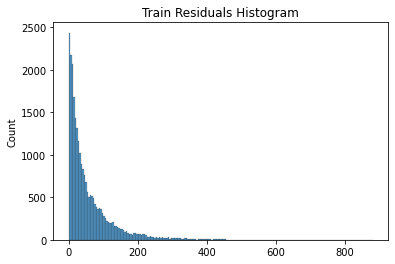

In [29]:
plot_residual_histogram(ypred, ytrue).set_title('Train Residuals Histogram');

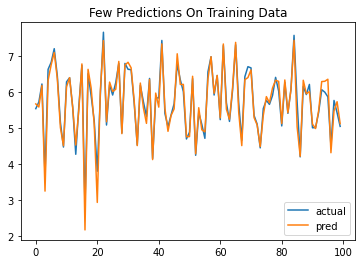

In [30]:
plot_predictions(ypred[:100], ytrue[:100])
plt.title("Few Predictions On Training Data");

In [31]:
print("Train Set Report")
report(ypred, ytrue)

Train Set Report


mean_absolute_error          57.786537
root_mean_square_error       90.318970
r_squared                     0.936635
max_error                   882.436218
observations              25830.000000
dtype: float64

validation set

In [32]:
ypred, ytrue = predict(model, val_dl)

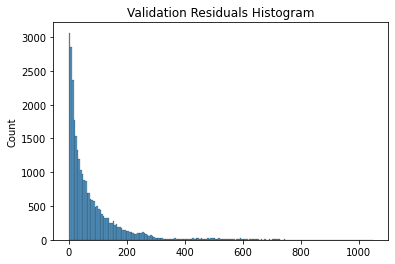

In [33]:
plot_residual_histogram(ypred, ytrue).set_title('Validation Residuals Histogram');

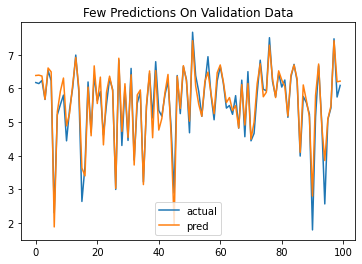

In [34]:
plot_predictions(ypred[:100], ytrue[:100])
plt.title("Few Predictions On Validation Data");

In [35]:
print("Validation Set Report")
report(ypred, ytrue)

Validation Set Report


mean_absolute_error          78.637405
root_mean_square_error      130.918839
r_squared                     0.897482
max_error                  1049.312744
observations              29454.000000
dtype: float64